# Solve the constrained monitoring problem by state-augmentation with augmenting dual multipliers sampled from a diffusion model.

The canonical constrained monitoring MDP problem with three states (c.f. https://arxiv.org/abs/2102.11941) is
$
\begin{align}
    \max_{\pi} \quad &V_0(\pi) \nonumber \\
    \text{subject to} \quad &V_i(\pi) \geq c_i, \quad i = 1, 2. \tag{CRL}
\end{align}
$
where each of the value functions measure the visitation frequency of their respective states and we assume $c_i = 1/3$ for all $i$.

An optimal state-augmented RL policy $\pi^\star_{\mathrm{SA}} = \pi_{\theta_{\mathrm{SA}}^\star}$ is trained to learn Lagrangian maximizing policies for any given dual multiplier vector $\lambda \succcurlyeq 0$. Given such a parametrization and KL-regularization, we can approximately find the dual function minimizers.
Instead of training a state-augmented RL policy over an arbitrary dual multiplier distribution and running dual dynamics online, we find the importance-sampling likelihood ratio for a regularized version of the problem at hand and train a diffusion model over the reweighed dual distribution to sample from neighborhoods of dual function minimizers.  

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import tqdm

fig_root_path = './figs'

# plt.rcParams['text.usetex'] = True

FIG_ROWSIZE = 6
FIG_COLSIZE = 6
FIG_FONTSIZE = 14
SCATTER_POINT_SIZE = 10.0

plt.rcParams.update({
    'font.size': FIG_FONTSIZE,
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}',

})

plt.style.use('bmh')


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device; ', device)


device;  cuda:0


### Define the environment, agent and policies.

In [2]:
from core.env import BaseEnv
from core.policy import Agent, OraclePolicy, LambdaSampler
from core.monitoring import MonitoringProblem
from core.config import config

env = BaseEnv(device=device)
oracle = OraclePolicy(device=device)
agent = Agent(device=device)

### Rollout episodes of the MDP with fixed dual multipliers (i.e., unconstrained MDP with fixed weighted rewards)

In [3]:
from collections import defaultdict

def visualize_monitoring(agent, env, n_episodes, n_timesteps, lambdas_sampler, lr_lambdas = 0.):
    all_variables_across_all_episodes = []
    for episode in tqdm.tqdm(range(n_episodes)):
        # state = env.reset()
        # lambdas_0 = lambdas_sampler.sample(n_samples = 1).squeeze(0)

        all_variables = defaultdict(list)
        for timestep in range(n_timesteps): # Limit timesteps as episode
            state = env.reset()
            lambdas_0 = lambdas_sampler.sample(n_samples = 1).squeeze(0)
            action = agent.select_action(augmented_state=(state, lambdas_0))
            new_state, rewards, _ = env.step(action=action)

            vars = {'timestep': timestep,
                    'old_state': (state, *lambdas_0.tolist()),
                    'new_state': (new_state, *lambdas_0.tolist()),
                    'action': action,
                    'rewards': rewards.tolist()
                    }
            
            for key in vars.keys():
                all_variables[key].append(vars[key])

            state = new_state

        all_variables_across_all_episodes.append({'episode': episode, 'variables': all_variables})

    return all_variables_across_all_episodes


env = BaseEnv(init_state=torch.randint(low=0, high=config.num_states, size = (1,)), device=device)
agent = Agent(device=device)
lambdas_sampler = LambdaSampler(lambdas_max=config.lambdas_max, n_lambdas=len(env.states) - 1, device=device)

all_metrics = visualize_monitoring(agent=agent,
                                   env=env,
                                   n_episodes=config.num_episodes,
                                   n_timesteps=config.num_timesteps,
                                   lambdas_sampler=lambdas_sampler
                                   )

100%|██████████| 100/100 [00:02<00:00, 49.35it/s]


### Visualize optimal deterministic policies.

In [4]:
import matplotlib.cm as cm
from matplotlib.colors import BoundaryNorm

def get_color_mapping(color_values, boundaries = None, color_thresh_low = np.Inf, color_thresh_high = -np.Inf, return_norm = False):

    if config.verbose >= 2:
        # Normalize color values to [0, 1]
        print(f'color.values.min() = {color_values.min()}')
        print(f'color.values.max() = {color_values.max()}')

    min_color_value = min(color_thresh_low, color_values.min())
    max_color_value = max(color_thresh_high, color_values.max())

    # Use a colormap
    cmap = plt.get_cmap('coolwarm')

    if boundaries is None:
        # norm = plt.Normalize(-1, 1)
        norm = plt.Normalize(min_color_value, max_color_value)
    else:
        norm = BoundaryNorm(boundaries, cmap.N)  # Create a norm based on boundaries

    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # This is important for the colorbar

    if return_norm:
        return sm, cmap, norm
    else:
        return sm, cmap

0.6628
0.6732
0.664


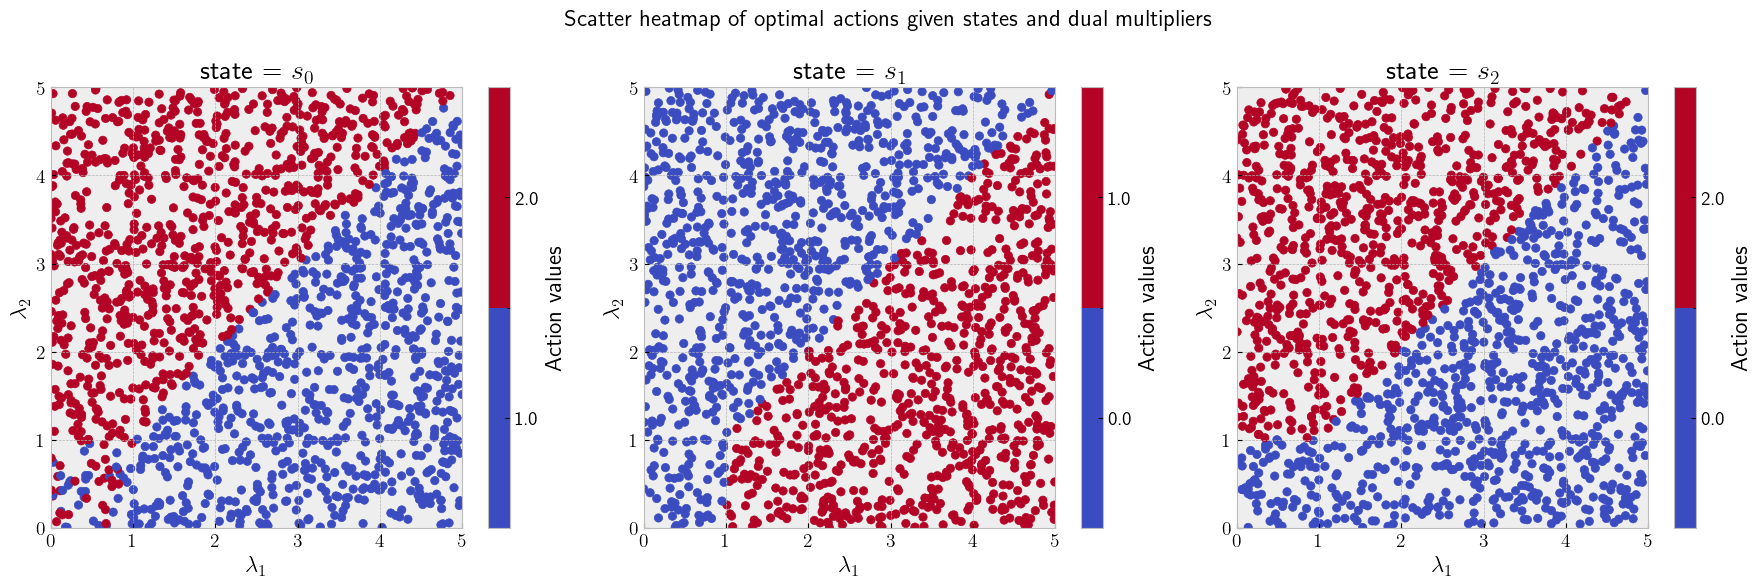

2.0


In [5]:
# Collect all augmented states and actions #
all_aug_states = []
all_actions = []
all_rewards = []
for episode, metrics in enumerate(all_metrics):
    aug_states = torch.tensor(metrics['variables']['old_state']).T.detach().cpu().numpy()
    actions = torch.tensor(metrics['variables']['action']).unsqueeze(0).detach().cpu().numpy()
    rewards = torch.tensor(metrics['variables']['rewards']).T.detach().cpu().numpy()

    all_aug_states.append(aug_states)
    all_actions.append(actions)
    all_rewards.append(rewards)

all_aug_states = np.stack(all_aug_states, axis = -1)
all_actions = np.stack(all_actions, axis = -1)
all_rewards = np.stack(all_rewards, axis = -1)

# print('all_aug_states: ', all_aug_states.shape)
# print('all_actions: ', all_actions.shape)

valid_idx_fraction = 0
fig, axs = plt.subplots(1, config.num_states, figsize = (config.num_states * FIG_COLSIZE, FIG_ROWSIZE))

for state in range(config.num_states):
    cond = all_aug_states[0] == state
    select_aug_states = np.where(cond, all_aug_states, np.nan)
    select_actions = np.where(cond, all_actions, np.nan)
    print(np.mean(np.isnan(select_aug_states)))
    valid_idx_fraction += np.mean(np.isnan(select_aug_states)).item()

    # print('select_actions.shape: ', select_actions.shape)
    # print('select_actions[filtered].shape: ', select_actions[~np.isnan(select_actions)].shape)
    # print('select_aug_states[1][filtered].shape: ', select_aug_states[1][~np.isnan(select_aug_states[1])].shape)
    # print('select_aug_states[2][filtered].shape: ', select_aug_states[2][~np.isnan(select_aug_states[2])].shape)

    select_actions = select_actions[~np.isnan(select_actions)]
    select_lambdas = np.stack((select_aug_states[1][~np.isnan(select_aug_states[1])], select_aug_states[2][~np.isnan(select_aug_states[2])]), axis = 0)

    if state == 1:
        pass
        # select_actions = np.random.randint(low = 0, high = config.num_states, size = select_actions.size)

    cmap_boundaries = np.linspace(start=select_actions.min(), stop=select_actions.max(), num = np.unique(select_actions).size + 1) # range(config.num_states) # None
    
    if cmap_boundaries is not None:
        cmap_ticks = []
        for i in range(len(cmap_boundaries)-1):
            cmap_ticks.append((cmap_boundaries[i] + cmap_boundaries[i+1])/2)
        cmap_ticks = np.array(cmap_ticks)

        # print('cmap_bound:',  cmap_boundaries)
        cmap_ticklabels = np.unique(select_actions)

    sm, cmap = get_color_mapping(select_actions, boundaries=cmap_boundaries)

    axs[state].scatter(x = select_lambdas[0].flatten(), y = select_lambdas[1].flatten(), c = select_actions, cmap = cmap)
    cbar = plt.colorbar(ax = axs[state], mappable=sm, label = 'Action values')
    if cmap_boundaries is not None:
        # cbar.set_ticks(cmap_boundaries)
        cbar.set_ticks(cmap_ticks)
        cbar.set_ticklabels(cmap_ticklabels)

    axs[state].set_xlabel(r'$\lambda_1$')
    axs[state].set_ylabel(r'$\lambda_2$')
    axs[state].set_xlim([0, config.lambdas_max])
    axs[state].set_ylim([0, config.lambdas_max])
    axs[state].grid(True)

    axs[state].set_title(r'state = $s_{}$'.format(state))

plt.suptitle('Scatter heatmap of optimal actions given states and dual multipliers')

fig.tight_layout()
plt.savefig(f'{fig_root_path}/optimal_actions.pdf', dpi = 300)
plt.show(fig)
print(valid_idx_fraction)


Show that sampling $\lambda \sim p_T(\lambda) := \mathcal{U}(\lambda; 0, \lambda_{\max})$ does not yield an optimal hyperpolicy necessarily.

In [6]:
print(r'Reward slacks expectation over U(0, \lambda_{\max})$ (positive is good): ', all_rewards.mean(axis = (1, 2)) - np.array(agent.policy_net.c))

best_obj_and_constraints = [(np.max(all_rewards[i].flatten()), np.argmax(all_rewards[i].flatten())) for i in range(len(all_rewards))]
rewards = []
for (val, idx) in best_obj_and_constraints:
    temp = np.array([all_rewards[_].flatten()[idx] for _ in range(len(all_rewards))])
    rewards.append(temp)

rewards = np.stack(rewards, axis = -1)
print(r'Best rewards attained: ',  rewards)

feasibility_mask = ( (all_rewards - np.expand_dims(agent.policy_net.c, axis = (1, 2)))[1] >=0 ) * ( (all_rewards - np.expand_dims(agent.policy_net.c, axis = (1, 2)))[2] >=0 )
assert feasibility_mask.any() == False
print("No deterministic policy is strictly feasible.")

Reward slacks expectation over U(0, \lambda_{\max})$ (positive is good):  [ 0.01126667 -0.01033333 -0.00093333]
Best rewards attained:  [[1 0 0]
 [0 1 0]
 [0 0 1]]
No deterministic policy is strictly feasible.


### Compute value functions.

Computing $V(\pi^\star, \lambda)$ for a set of dual multipliers.


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:37<00:00,  5.31it/s]


values:  torch.Size([3, 200])
lambdas.shape
constraint slacks:  torch.Size([200])


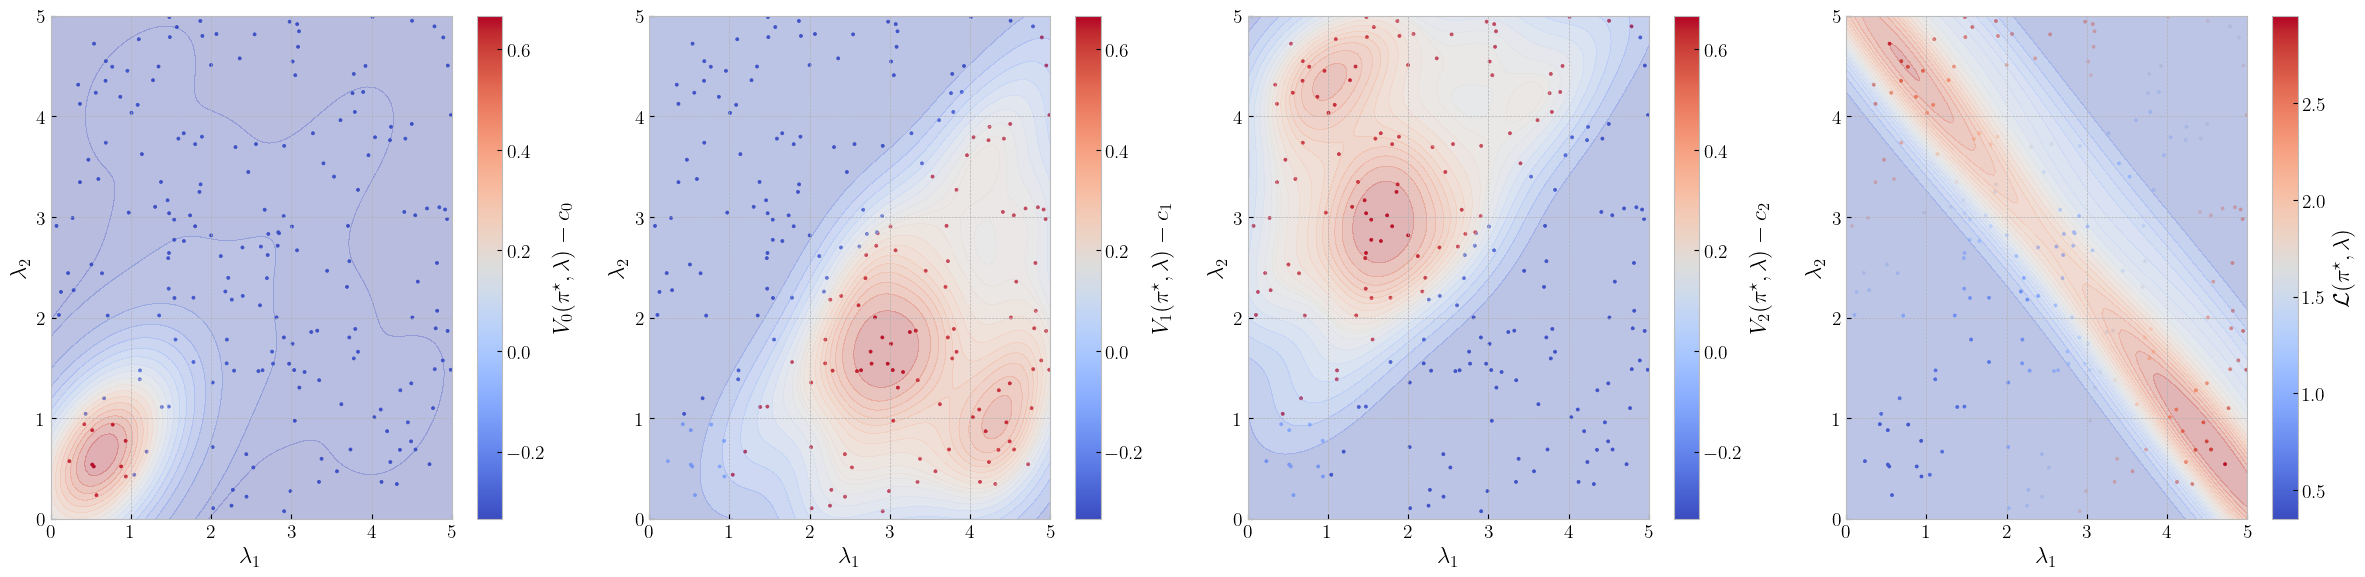

In [19]:
import scipy.stats as st

def contour_kde(xx, yy):
    """ 
    https://stackoverflow.com/questions/42602425/overlay-contour-plots-in-matplotlib?rq=3
    """
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    return f

    # plt.contourf(xx, yy, f, cmap=cmap, alpha=0.5)


env = BaseEnv(device=device)
agent = Agent(device=device)
policy = OraclePolicy(device=device)

problem = MonitoringProblem(env=env, agent=agent, policy=policy, device=device)
lambdas_all = lambdas_sampler.sample(n_samples = 200)
values = problem.value_func(lambdas_list=[lambdas for lambdas in lambdas_all])
lagrangians_all = problem.lagrangian(lambdas=lambdas_all, values=values.T)


fig, axs = plt.subplots(1, values.shape[-1] + 1, figsize = ((values.shape[-1] + 1) * FIG_COLSIZE, FIG_ROWSIZE))
sm, cmap = get_color_mapping(values - torch.tensor(policy.c).view(1, -1).to(values.device), boundaries=None)

for i, ax in enumerate(axs.flat):
    
    if i < len(values.T):   
        x, y, c = lambdas_all.T[0].flatten().detach().cpu(), lambdas_all.T[1].flatten().detach().cpu(), values.T[i].detach().cpu() - policy.c[i]
        # sm, cmap = get_color_mapping(c, boundaries=None)
        ax.scatter(x = x, y = y, c = c, cmap = cmap, s = 5.0)

        cbar = plt.colorbar(ax = ax, mappable=sm, label = r'$V_{}(\pi^\star, \lambda) - c_{}$'.format(i, i))
    else:
        x, y, c = lambdas_all.T[0].flatten().detach().cpu(), lambdas_all.T[1].flatten().detach().cpu(), lagrangians_all.detach().cpu()

        sm, cmap = get_color_mapping(lagrangians_all, boundaries=None)

        # sm, cmap = get_color_mapping(c, boundaries=None)
        ax.scatter(x = x, y = y, c = c, cmap = cmap, s = 5.0)

        cbar = plt.colorbar(ax = ax, mappable=sm, label = r'$\mathcal{L}(\pi^\star, \lambda)$')

    # Step 3: Overlay the KDE contours
    kde_tau = 10.
    sns.kdeplot(x=x, y=y, weights = (kde_tau * (c - c.max())).exp(), cmap=cmap, fill=True, thresh=0, levels=20, alpha=0.3, ax = ax, cbar_ax = cbar)    

    # # sns.kdeplot(data = c, x=x, y=y, fill=True, thresh=0, levels=20, ax = ax)

    # xx, yy = np.meshgrid(x, y)
    # f = contour_kde(xx, yy)

    # ax.contourf(xx, yy, f, c = c, cmap=cmap, alpha=0.3)

    # ax.contourf(xx, yy, cmap = cmap)

    ax.set_xlabel(r'$\lambda_1$')
    ax.set_ylabel(r'$\lambda_2$')
    ax.set_xlim([0, config.lambdas_max])
    ax.set_ylim([0, config.lambdas_max])
    ax.grid(True)
    # ax.set_title(r'$V_{}(\pi^\star, \lambda) - c_{}$'.format(i, i))

fig.tight_layout()
plt.savefig(f'{fig_root_path}/value_heatmap.pdf', dpi = 300)
plt.show(fig)

### Compute importance sampling RN-Density
The RN-density is given by a $\tau$-scaled Lagrangian exponentiated, i.e., $q^\star(\lambda) \propto e^{-\tau \mathcal{L}(\pi^\star, \lambda)}$ where $1 / \tau$ for $\tau \in (0, \infty)$ is the strength of KL Divergence to the dual multiplier sampling distribution.

Computing $V(\pi^\star, \lambda)$ for a set of dual multipliers.


100%|██████████| 200/200 [00:38<00:00,  5.24it/s]


values:  torch.Size([3, 200])
lambdas.shape
constraint slacks:  torch.Size([200])
lagrangians_all:  torch.Size([200])


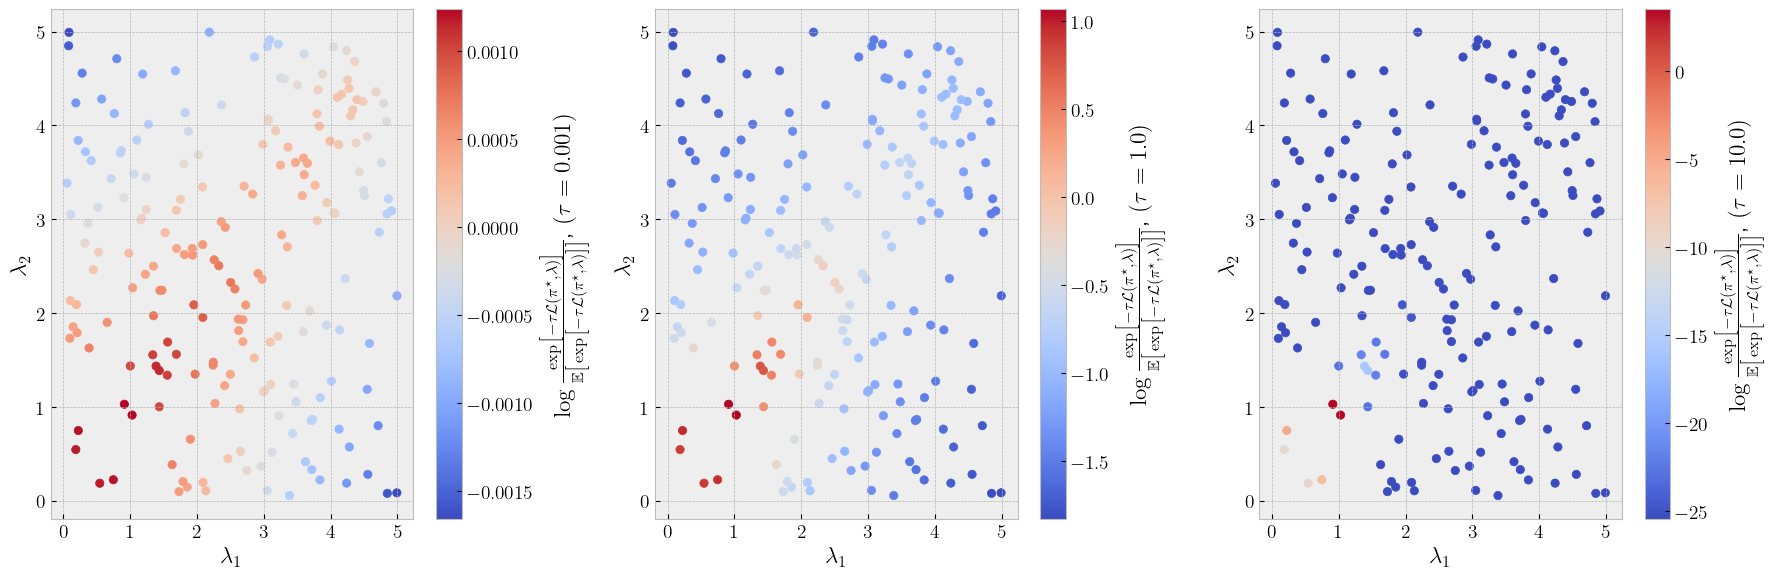

In [22]:
from torch.utils.data import TensorDataset, Dataset
from torch.utils.data.sampler import WeightedRandomSampler

class ZippedDataset(Dataset):
    def __init__(self, datasets):
        self.datasets = datasets

    def __len__(self):
        # Return the length of the shorter dataset
        return min([len(dataset) for dataset in self.datasets])

    def __getitem__(self, idx):
        items = [dataset[idx] for dataset in self.datasets]
        return (*items,)
    

def importance_sampler(X_0, Y_0 = None, weights = None, batch_size = 1000, replacement = True):
    X_dataset = TensorDataset(X_0)
    if Y_0 is not None:
        Y_dataset = TensorDataset(Y_0)
        dataset = ZippedDataset([X_dataset, Y_dataset])
    else:
        dataset = X_dataset

    weights = torch.ones_like(len(X_dataset)) if weights is None else weights
    sampler = WeightedRandomSampler(weights, len(weights), replacement = replacement)
    dataloader = torch.utils.data.DataLoader(dataset=dataset,
                                             sampler=sampler,
                                             batch_size = batch_size,
                                             drop_last = False
                                             )
    return dataloader

lambdas_all = lambdas_sampler.sample(n_samples = 200)
lagrangians_all = problem.lagrangian(lambdas=lambdas_all,
                                    #  values = values.T
                                     )
print('lagrangians_all: ', lagrangians_all.shape)

tau_list = [0.001, 1., 10.]
fig, axs = plt.subplots(1, len(tau_list), figsize = (len(tau_list) * FIG_COLSIZE, FIG_ROWSIZE))

for tau, ax in zip(tau_list, axs.flat):
    weights = (-tau * lagrangians_all).exp() / (-tau * lagrangians_all).exp().mean()

    # color = lagrangians.detach().cpu() * weights.detach().cpu() # lagrangians.cpu()
    # color = lagrangians.detach().cpu()

    Q_star_dataloader = importance_sampler(X_0=lambdas_all,
                                        #    Y_0=lagrangians_all,
                                           Y_0=weights,
                                           weights=weights,
                                           batch_size=100,
                                           replacement=False
                                           )

    x_data, y_data = [], []
    for q_data in Q_star_dataloader:
        x_data.append(q_data[0][0].cpu())
        y_data.append(q_data[1][0].cpu())
    
    scatter_data = torch.cat(x_data, dim = 0)
    color_data = torch.cat(y_data, dim = 0)

    sm, cmap = get_color_mapping(color_data.log().detach().cpu(), boundaries=None)
    # print('color.mean() after get_color_mapping(): ', color_data.mean().item())

    ax.scatter(scatter_data[:, 0].cpu(), scatter_data[:, 1].cpu(), c = color_data, cmap = cmap)
    ax.grid(True)

    ax.set_xlabel(r'$\lambda_1$')
    ax.set_ylabel(r'$\lambda_2$')

    cbar = plt.colorbar(ax = ax, mappable=sm, label = r'$\log \frac{\exp \big[-\tau \mathcal{L}(\pi^\star, \lambda) \big]}{\mathbb{E} \Big[ \exp \big[-\tau \mathcal{L}(\pi^\star, \lambda) \big]  \Big]}$' +  r',  $(\tau = {})$'.format(tau))
# ax.grid(True)
# ax.legend(loc = 'best')
# ax.title('Importance sampling via Value function repr. of the RN density')
fig.tight_layout()
plt.savefig(f'{fig_root_path}/importance_sampling_density.pdf', dpi = 300)
plt.show()
plt.close(fig)


As the regularization becomes weaker ($1 / \tau \to 0$), importance sampling density evolves to an atomic measure with all the masses accumulating over optimal dual multipliers, i.e., dual function minimizers.

## Create a training dataset and test out the noise scheduling pipeline.

Computing $V(\pi^\star, \lambda)$ for a set of dual multipliers.


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:37<00:00,  5.29it/s]


values:  torch.Size([3, 200])
lambdas.shape
constraint slacks:  torch.Size([200])


Text(0.5, 1.0, 'Training Dataset of Dual Multipliers')

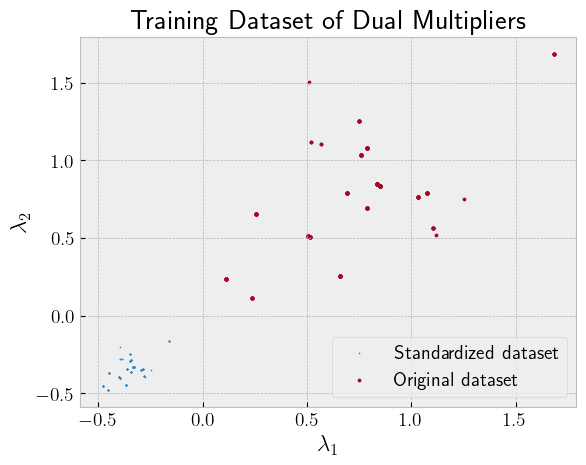

In [23]:
import torch.nn as nn
class LambdaNormalization(nn.Module):
    def __init__(self, x_min = 0, x_max = config.lambdas_max, x_target_min = -1/2, x_target_max = 1/2):
        super().__init__()
        self.x_min = x_min
        self.x_max = x_max
        self.x_target_min = x_target_min
        self.x_target_max = x_target_max

        "Linear transformation with slope m and offset b"
        self.m = (self.x_target_max - self.x_target_min) / (self.x_max - self.x_min)
        self.b = self.x_target_max - self.m * self.x_max
        assert np.abs(self.b - (self.x_target_min - self.m * self.x_min)) < 1e-6, 'Slope calculation error!'

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        return self.m * x + self.b
    
    def reverse(self, x):
        "Invert the linear transformation"
        return LambdaNormalization(x_min=self.x_target_min,
                                   x_max=self.x_target_max,
                                   x_target_min=self.x_min,
                                   x_target_max=self.x_max
                                   )(x)
    

class WeightedLambdaSampler(LambdaSampler):
    def __init__(self, weight_func, device = 'cpu'):
        super(WeightedLambdaSampler, self).__init__(device=device)
        self.weight_func = weight_func

    def sample(self, dataloader = None, n_samples = 1, flip_symmetry = True, batch_size = 100, sample_single_batch = False):
        if dataloader is None:
            unweighted_samples = super().sample(n_samples=n_samples, flip_symmetry=flip_symmetry)
            weights = self.weight_func(unweighted_samples)

            dataloader = importance_sampler(X_0=unweighted_samples,
                                            weights=weights,
                                            batch_size=batch_size,
                                            replacement=True
                                            )
        data = []
        for i, temp in enumerate(dataloader):
            data.append(temp[0])
            if sample_single_batch:
                break
        data = torch.cat(data, dim = 0)

        return data, dataloader
    

def make_weight_func(tau = 1.):
    def weight_func(lambdas_all):
        lagrangians_all = problem.lagrangian(lambdas=lambdas_all)
        weights = (-tau * lagrangians_all).exp() / (-tau * lagrangians_all).exp().mean()

        return weights
    return weight_func

    
# Create a dataset, weighted dataloader and apply normalization
lambdas_all = lambdas_sampler.sample(n_samples=200, flip_symmetry=True)
weighted_lambdas_sampler = WeightedLambdaSampler(weight_func=make_weight_func(tau=config.tau), device=device)
weighted_lambdas_all, weighted_dataloader = weighted_lambdas_sampler.sample(dataloader=None, n_samples=200, batch_size=config.batch_size, sample_single_batch=False)

lambdas_norm = LambdaNormalization()
X = lambdas_norm(weighted_lambdas_all).to(device)
X_0 = lambdas_norm.reverse(X).to(device)

plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), s = 0.5, label = 'Standardized dataset')
plt.scatter(X_0[:, 0].cpu(), X_0[:, 1].cpu(), s = 5., label = 'Original dataset')
plt.xlabel(r'$\lambda_1$')
plt.ylabel(r'$\lambda_2$')
plt.grid(True)
plt.legend(loc = 'best')
plt.title('Training Dataset of Dual Multipliers')

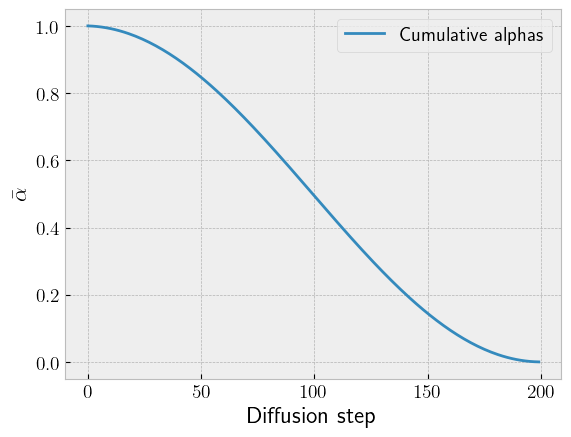

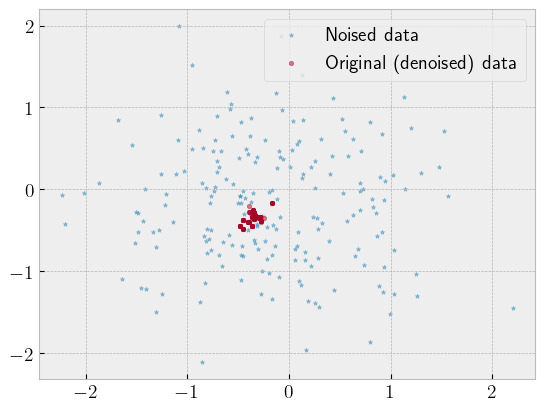

In [24]:
diffusion_steps = config.diffusion_steps  # Number of steps in the diffusion process
beta_schedule = config.beta_schedule

if beta_schedule == 'linear':
    beta_min = 0.1
    beta_max = 20
    betas = torch.linspace(beta_min / diffusion_steps, beta_max / diffusion_steps, diffusion_steps).to(device=device)
    alphas = 1 - betas
    baralphas = torch.cumprod(alphas, dim = 0).to(device = device)

elif beta_schedule == 'cosine':
    # Set noising variances betas as in Nichol and Dariwal paper (https://arxiv.org/pdf/2102.09672.pdf)
    s = 0.008
    timesteps = torch.tensor(range(0, diffusion_steps), dtype=torch.float32, device=device)
    schedule = torch.cos((timesteps / diffusion_steps + s) / (1 + s) * torch.pi / 2)**2

    baralphas = schedule / schedule[0]
    # betas = 1 - baralphas / torch.concatenate([baralphas[0:1], baralphas[0:-1]])
    betas = 1 - baralphas / torch.cat([baralphas[0:1], baralphas[0:-1]])
    alphas = 1 - betas

else:
    raise NotImplementedError

# Check the cumulative alphas follow the distribution recommended in the paper
sns.lineplot(baralphas.cpu(), linestyle = '-', label = 'Cumulative alphas')
# sns.lineplot(sde.alphas_cumprod.cpu(), linestyle = '--', label = 'VPSDE cumulative alphas')
plt.xlabel("Diffusion step")
plt.ylabel(r"$\bar{\alpha}$")
plt.grid(True)
plt.legend(loc = 'best')
plt.show()


def noise(Xbatch, t):
    eps = torch.randn(size=Xbatch.shape).to(Xbatch.device)
    noised = (baralphas[t] ** 0.5).repeat(1, Xbatch.shape[1]) * Xbatch + ((1 - baralphas[t]) ** 0.5).repeat(1, Xbatch.shape[1]) * eps
    return noised, eps

noiselevel = diffusion_steps // 2 #20

noised, eps = noise(X, torch.full([len(X), 1], fill_value=noiselevel))
plt.scatter(noised[:, 0].cpu(), noised[:, 1].cpu(), s = SCATTER_POINT_SIZE, marker="*", alpha=0.5)
plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), s = SCATTER_POINT_SIZE, alpha=0.5)
plt.grid(True)
plt.legend(["Noised data", "Original (denoised) data"])
plt.show()

## Diffusion Network

Now we define a pytorch network that will learn to predict the noise component from noised data.

In [31]:
import torch.nn as nn

## Unconditional FCNN diffusion model
class DiffusionBlock(nn.Module):
    def __init__(self, nunits):
        super(DiffusionBlock, self).__init__()
        self.linear = nn.Linear(nunits, nunits)
        
    def forward(self, x: torch.Tensor):
        x = self.linear(x)
        x = nn.functional.relu(x)
        return x
        
    
class DiffusionModel(nn.Module):
    def __init__(self, nfeatures: int, nblocks: int = 2, nunits: int = 64):
        super(DiffusionModel, self).__init__()
        
        self.inblock = nn.Linear(nfeatures+1, nunits)
        self.midblocks = nn.ModuleList([DiffusionBlock(nunits) for _ in range(nblocks)])
        self.outblock = nn.Linear(nunits, nfeatures)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        val = torch.hstack([x, t])  # Add t to inputs
        val = self.inblock(val)
        for midblock in self.midblocks:
            val = midblock(val)
        val = self.outblock(val)
        return val
    

## Conditional Linear diffusion model
import torch.nn.functional as F

class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x: torch.Tensor, y: torch.Tensor):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out # t + Graph

        out = F.softplus(out)
        return out
    
        
class ConditionalLinearModel(nn.Module):
    def __init__(self, nsteps, nfeatures: int, nblocks: int = 2, nunits: int = 128):
        super(ConditionalLinearModel, self).__init__()
        self.nsteps = nsteps
        self.inblock = ConditionalLinear(nfeatures, nunits, nsteps)
        self.midblock = nn.ModuleList([ConditionalLinear(nunits, nunits, nsteps) for _ in range(nblocks)])
        self.outblock = nn.Linear(nunits, nfeatures)
    
    def forward(self, x: torch.Tensor, t: torch.Tensor):
        val = self.inblock(x, t)
        for midblock in self.midblock:
            val = midblock(val, t)
        val = self.outblock(val)
        return val

In [32]:
nblocks = 4
nunits = 128
model = ConditionalLinearModel(nsteps=diffusion_steps, nfeatures=2, nblocks=nblocks, nunits=nunits)
is_model_trained = False

if config.model_load_path is not None:
    try:
        model.load_state_dict(torch.load(config.model_load_path))
        print(f'Loading pretrained model weights from {config.model_load_path} is successful.')
        is_model_trained = True

    except:
        print(f'Could not load model state dict from {config.model_load_path}! Training model from scratch.')

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

### Train a diffusion model to learn sampling from $\tau$-regularized Lagrangian-maximizing dual multipliers.

In [33]:
# Define loggers for training loss evolution (and more...)
from utils.logger_utils import DiffusionLossLogger

loggers = [DiffusionLossLogger(data = [], log_path = f"./logs")]

In [34]:
import torch.optim as optim

if not is_model_trained:

    nepochs = config.num_epochs
    batch_size = config.batch_size
    lr = config.lr
    end_factor = 0.01

    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=nepochs)

    dataloader = weighted_dataloader

    all_variables = defaultdict(list)
    for epoch in tqdm.tqdm(range(nepochs)):
        epoch_loss = steps = 0
        i = 0 
        for data in dataloader:
        # for i in range(0, len(X), batch_size):
            # Xbatch = X[i:i+batch_size]
            # Xbatch = Xbatch[0]
            data = data[0].to(device)
            Xbatch = lambdas_norm(data)

            perturb_sigma = 0.05
            Xbatch += perturb_sigma * torch.randn_like(Xbatch)
            timesteps = torch.randint(0, diffusion_steps, size=[len(Xbatch), 1])
            noised, eps = noise(Xbatch, timesteps)
            predicted_noise = model(noised.to(device), timesteps.to(device))
            loss = loss_fn(predicted_noise, eps.to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss
            steps += 1
            i += 1
        
        epoch_loss = epoch_loss / steps
        all_variables['loss'] = epoch_loss.item()

        for logger in loggers:
            logger.update_data(all_variables)
            if (epoch + 1) % config.chkpt_every_n_epochs == 0:
                # print(f"Epoch {epoch} loss = {epoch_loss}")
                logger()
    

100%|██████████| 20000/20000 [04:28<00:00, 74.44it/s] 


Run DDPM sampler with the trained model.

In [35]:
def sample_ddpm(model, nsamples, nfeatures):
    """Sampler following the Denoising Diffusion Probabilistic Models method by Ho et al (Algorithm 2)"""
    with torch.no_grad():
        x = torch.randn(size=(nsamples, nfeatures)).to(device)
        xt = [x]
        for t in range(diffusion_steps-1, 0, -1):
            predicted_noise = model(x, torch.full([nsamples, 1], t).to(device))
            # See DDPM paper between equations 11 and 12
            x = 1 / (alphas[t] ** 0.5) * (x - (1 - alphas[t]) / ((1-baralphas[t]) ** 0.5) * predicted_noise)
            if t > 1:
                # See DDPM paper section 3.2.
                # Choosing the variance through beta_t is optimal for x_0 a normal distribution
                variance = betas[t]
                std = variance ** (0.5)
                x += std * torch.randn(size=(nsamples, nfeatures)).to(device)
            xt += [x]
        return x, xt

Test generations by sampling 1000 points from a Gaussian prior.

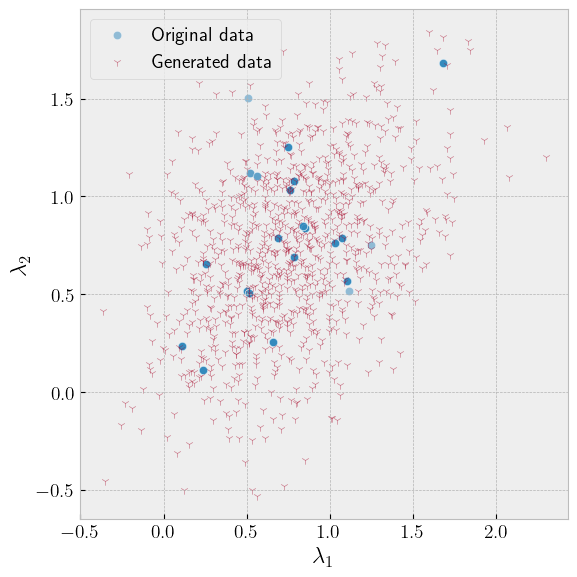

In [38]:
import pandas as pd

Xgen, Xgen_hist = sample_ddpm(model, 1000, 2)
Xgen = lambdas_norm.reverse(Xgen).cpu()
# Xgen = Xgen.cpu()

df_X_0 = pd.DataFrame(X_0.cpu().numpy(), columns = [r"$\lambda_1$", r"$\lambda_2$"])
df_Xgen = pd.DataFrame(Xgen.cpu().numpy(), columns = [r"$\lambda_1$", r"$\lambda_2$"])

# df = pd.DataFrame(np.vstack(X_0.cpu().numpy(), Xgen.numpy()), columns=["x", "y"], labels = np.vstack(np.zeros_like(X_0[:, 0].cpu().numpy()), np.ones_like(Xgen[:, 0].cpu().numpy())))
fig, ax = plt.subplots(1, 1, figsize = (FIG_COLSIZE, FIG_ROWSIZE))

sns.scatterplot(x=df_X_0[r"$\lambda_1$"], y=df_X_0[r"$\lambda_2$"], marker = 'o', alpha = 0.5, label = "Original data", ax = ax)
sns.scatterplot(x=df_Xgen[r"$\lambda_1$"], y=df_Xgen[r"$\lambda_2$"], marker = "1", alpha = 0.5, label = "Generated data", ax = ax)
# plt.scatter(X_0[:, 0].cpu(), X_0[:, 1].cpu(), s = SCATTER_POINT_SIZE, alpha=0.5)
# plt.scatter(Xgen[:, 0], Xgen[:, 1], s = SCATTER_POINT_SIZE, marker="1", alpha=0.5)
ax.legend(loc = 'best')
plt.tight_layout()
plt.savefig(f"{fig_root_path}/ddpm_sampler_tau_{config.tau}.pdf", dpi = 300)
plt.show()